# 🚀 Criteo Uplift Prediction — S-Learner with XGBoost
 
**Goal**: Predict the individual treatment effect (ITE) of an ad exposure on user visitation.

- **Treatment**: User shown ad (treatment=1) vs not shown (treatment=0)
- **Outcome**: User visits website within 2 weeks (`conversion`)
- **Exposure**: Only some `treatment=1` users were actually exposed (`exposure=1`)
 
We'll use **S-Learner** (single model with treatment as feature) + **XGBoost**.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import auc
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 16)
pd.set_option('display.max_columns', None)

## Dataset

#### Context
Uplift modeling is an important yet novel area of research in machine learning which aims to explain and to estimate the causal impact of a treatment at the individual level. In the digital advertising industry, the treatment is exposure to different ads and uplift modeling is used to direct marketing efforts towards users for whom it is the most efficient . The data is a collection collection of 13 million samples from a randomized control trial, scaling up previously available datasets by a healthy 590x factor.

#### Content
The dataset was created by The Criteo AI Lab .The dataset consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions). Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks). The global treatment ratio is 84.6%. It is usual that advertisers keep only a small control population as it costs them in potential revenue.

Following is a detailed description of the features:

- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
- treatment: treatment group (1 = treated, 0 = control)
- conversion: whether a conversion occured for this user (binary, label)
- visit: whether a visit occured for this user (binary, label)
- exposure: treatment effect, whether the user has been effectively exposed (binary)

[1]: https://www.kaggle.com/arashnic/uplift-modeling/

In [3]:
# df = pd.read_csv('/kaggle/input/criteo-uplift-prediction/criteo-uplift.csv') #if run in the kaggle 
df=pd.read_csv('./data/criteo-uplift.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [5]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## EDA

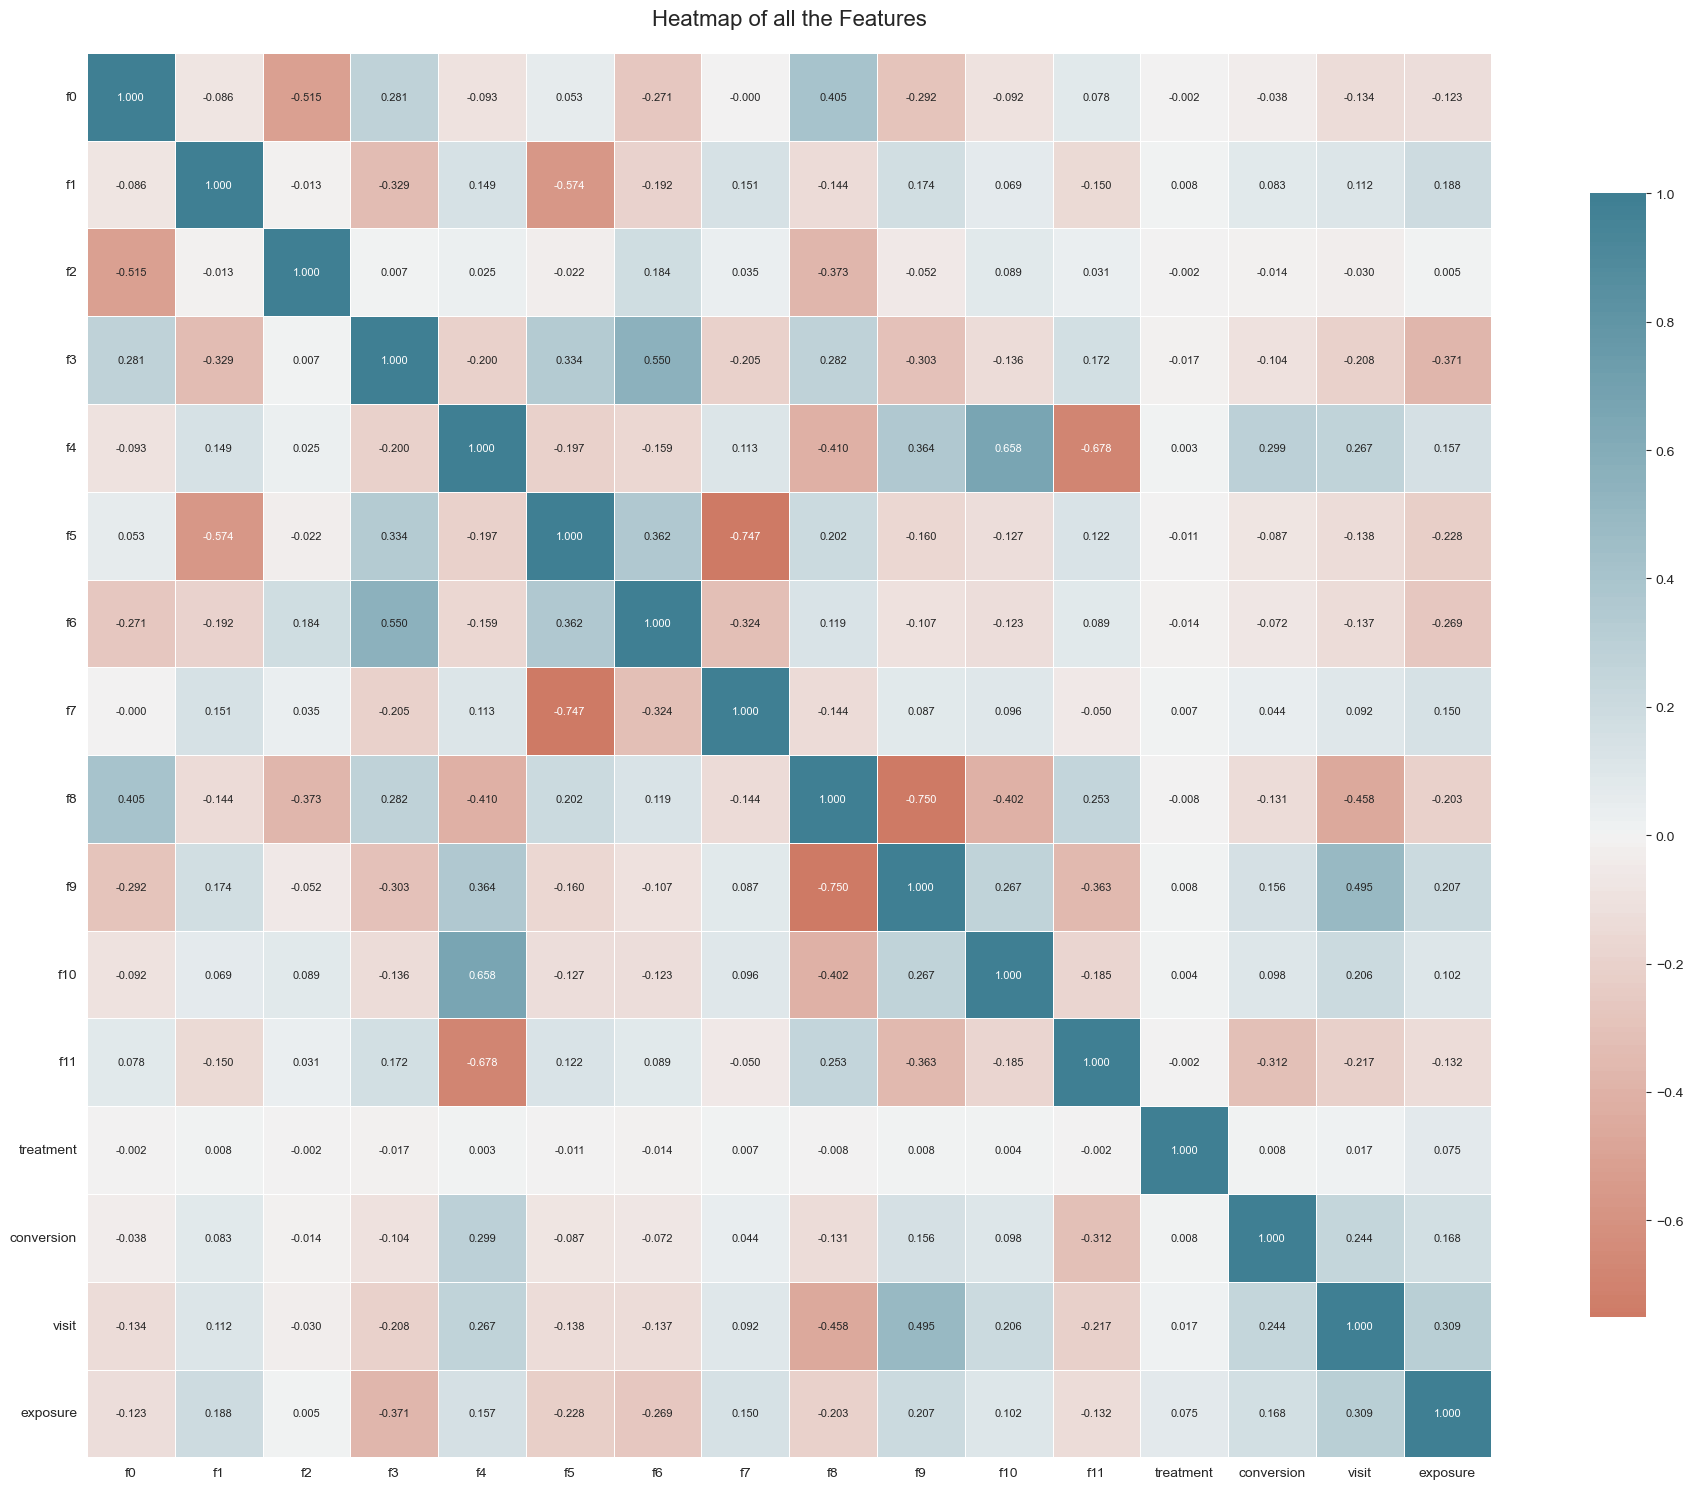

In [13]:

corr_matrix = df.corr()

style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,15))

ax = sns.heatmap(
    corr_matrix,
    annot=True,           
    fmt=".3f",            
    cmap=sns.diverging_palette(20, 220, n=200),
    center=0, 
    square=True,        
    linewidths=0.5,      
    cbar_kws={'shrink': 0.8}, 
    annot_kws={'size': 8} 
)

plt.title('Heatmap of all the Features', fontsize=16, pad=20)
plt.xticks(rotation=0) 
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

- Conversion has a weak positive correlation with f4 (0.3).
- f10 and f4 have a strong positive correlation (0.66).
- Conversion, visit, and exposure are positively correlated with each other.

In [14]:
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4))) #访问率
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4))) #转化率
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4))) #访问转化率

Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


In [18]:
df['treatment'].value_counts(normalize=True)


treatment
1    0.85
0    0.15
Name: proportion, dtype: float64

In [20]:
vis_results_df = df.groupby('treatment').agg({'visit':['mean', 'sum', 'count']})
vis_results_df

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

In [21]:
con_results_df = df.groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})
con_results_df

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.003089  36711  11882655

In [22]:
print(f'Difference in clickthrough rate between control and treatment: {np.round(df.groupby("treatment")["visit"].mean()[1] - df.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Difference in conversion between control and treatment: {np.round(df.groupby("treatment")["conversion"].mean()[1] - df.groupby("treatment")["conversion"].mean()[0], 4)}')

Difference in clickthrough rate between control and treatment: 0.0103
Difference in conversion between control and treatment: 0.0012


- The visit rate of users who received treatment is 4.9%, higher than the control group's 3.8%. This indicates that treatment effectively encourages user visits, with a difference of approximately 1%.
- The conversion rate of treated users (0.31%) is higher than that of the control group (0.19%).

Treatment has a highly significant effect on both visits and conversions.

There is a "exposure" feature in the dataset that is also associated with "visit" and "exposure". We can also examine the distribution of its data.

In [23]:
exp_results_df = df.groupby('treatment').agg({'exposure':['mean', 'sum', 'count']})
exp_results_df

exposure                  
               mean     sum     count
treatment                            
0          0.000000       0   2096937
1          0.036037  428212  11882655

In [24]:
df[df['treatment']==1]['exposure'].value_counts(normalize = True)

exposure
0    0.963963
1    0.036037
Name: proportion, dtype: float64

It can be seen that all the exposures occurred in the treatment group, and only 3.6% of the users in the treatment group experienced the exposure.

In [25]:
vis_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'visit':['mean', 'sum', 'count']})
vis_exp_results_df

visit                  
              mean     sum     count
exposure                            
0         0.034861  399314  11454443
1         0.414538  177510    428212

In [26]:
con_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'conversion':['mean', 'sum', 'count']})
con_exp_results_df

conversion                 
               mean    sum     count
exposure                            
0          0.001194  13680  11454443
1          0.053784  23031    428212

Users in the treatment group who were effectively exposed to the ad had a click-through rate of 41%, far higher than the 3.5% rate among treated users who were not exposed. A similar pattern was observed for conversion: 5.3% of exposed users converted, compared to only 0.12% among unexposed treated users. These results indicate that the intervention is highly effective—however, too few users actually received the exposure.

## Resampling

Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


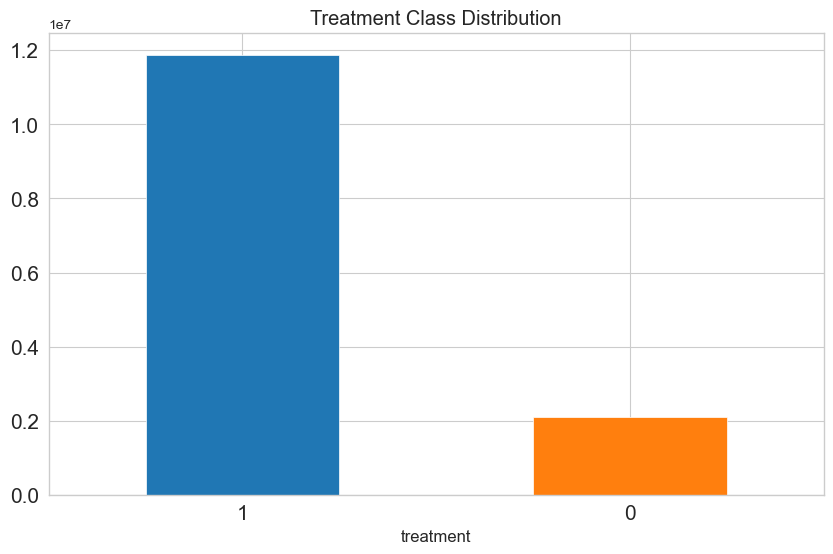

In [27]:
fig = plt.figure(figsize = (10,6))
target_count = df['treatment'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 
plt.show()

By examining the distribution, we can assess the skewness of the target variable—most users belong to the treatment group. The issue is that many uplift modeling methods assume balanced distributions between the treatment and control groups, an assumption that often does not hold in practice. In such cases, we can reweight or resample the training dataset to satisfy this assumption.

In [28]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment']) 

In [29]:
# Random under-sampling (identify the majority class and reduce the sampling of it)
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    #Keep the data volumes of the experimental group and the control group consistent.
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [30]:
train = random_under(train, 'treatment')

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


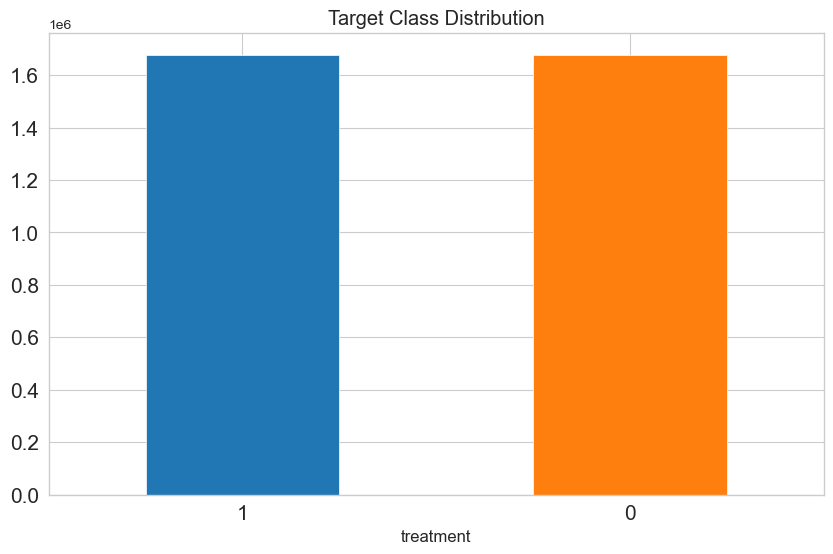

In [31]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['treatment'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 
plt.show()

As shown above, the new training dataset contains a total of 3,355,100 samples, with the treatment and control groups each accounting for 50%.

## uplift model

Since this is my first time applying uplift modeling, I’m following conventional practice and opting for the most straightforward approach: S-Learner with XGBoost.

In [ ]:
features = [f'f{i}' for i in range(12)]  # f0 到 f11
X_train = train[features]
X_test = test[features]

y_train = train['visit']
y_test = test['visit']

t_train = train['treatment']
t_test = test['treatment']

In [33]:
X_train_s = X_train.copy()
X_train_s['treatment'] = t_train
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1  # 多线程加速
)
model.fit(X_train_s, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [34]:
X_test_t0 = X_test.copy()
X_test_t0['treatment'] = 0  # control

X_test_t1 = X_test.copy()
X_test_t1['treatment'] = 1  # treatment

pred_0 = model.predict(X_test_t0)  # ŷ₀: P(C)
pred_1 = model.predict(X_test_t1)  # ŷ₁: P(T)
uplift_score = pred_1 - pred_0  # uplift = ŷ₁ - ŷ₀

In [36]:
uplift_score

array([0.00032862, 0.00269833, 0.00166485, ..., 0.00032862, 0.00069444,
       0.00032862], dtype=float32)

In [37]:
results = pd.DataFrame({
    'uplift': uplift_score,
    'treatment': t_test.values,
    'visit': y_test.values
}).sort_values('uplift', ascending=False).head()

print(results)

           uplift  treatment  visit
1127265  0.502894          1      1
2292870  0.493383          1      1
293218   0.484971          1      1
2728009  0.452200          1      1
933616   0.443240          1      1


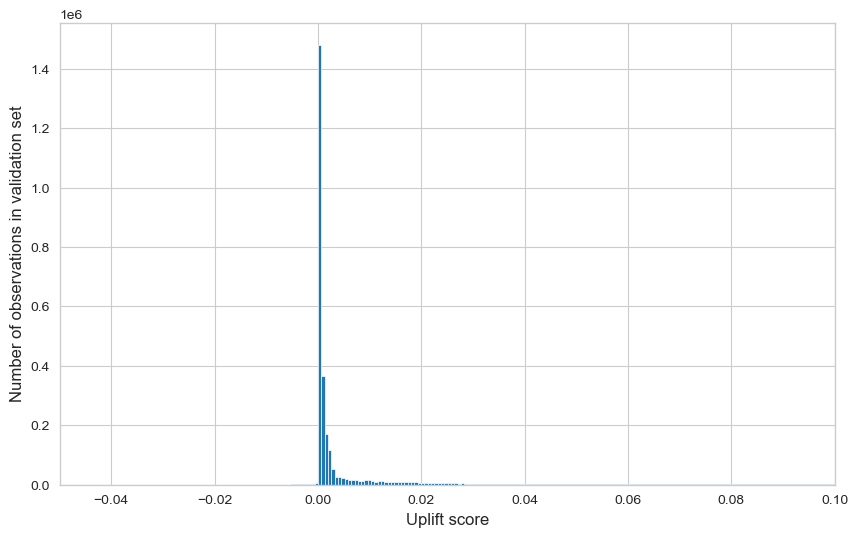

In [40]:
result = pd.DataFrame({
    'uplift': uplift_score,
    'treatment': t_test.values,
    'visit': y_test.values
})
plt.figure(figsize = (10,6))
plt.xlim(-.05, .1)
plt.hist(result.uplift, bins=1000, color=['#2077B4'])
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')
plt.show()

Most uplift scores are positive, which aligns with our prior analysis—effective treatment can indeed encourage user visits. However, we also observe that the majority of users have scores clustered near zero, indicating that the model’s ability to discriminate between high- and low-uplift individuals still needs improvement.

## Model evaluation

In [41]:
eval_df = pd.DataFrame({
    'uplift': uplift_score,
    'treatment': t_test.values,
    'visit': y_test.values
})

eval_df = eval_df.sort_values('uplift', ascending=False).reset_index(drop=True)

Incremental Visits = (#TR) - (#CR) × (N_T / N_C)

In [42]:
# TR and CR
tr = (eval_df['treatment'] == 1) & (eval_df['visit'] == 1)
cr = (eval_df['treatment'] == 0) & (eval_df['visit'] == 1)

cum_tr = tr.cumsum()
cum_cr = cr.cumsum()

# T and C
n_t = eval_df['treatment'].sum()
n_c = len(eval_df) - n_t

ratio = n_t / n_c

incremental_visits = cum_tr - cum_cr * ratio

Qini = AUC(Incremental Visits) - AUC(Random Line)

In [43]:
# X-axis: Proportion of intervention participants (ranging from 0 to 1)
x = np.arange(1, len(incremental_visits) + 1) / len(incremental_visits)

# Y-axis: Cumulative Incremental Visits
y = incremental_visits

# baseline: Assuming uniform distribution, the expected gain is total_gain multiplied by proportion.
total_gain = incremental_visits.iloc[-1]
random_line = x * total_gain

# AUC
auc_model = auc(x, y)
auc_random = auc(x, random_line)

# Qini
qini_coefficient = auc_model - auc_random

print(f"Qini Coefficient: {qini_coefficient:.4f}")

Qini Coefficient: 11174.9461


In [44]:
def get_top_k_uptime_ratio(k):
    idx = int(len(eval_df) * k / 100)
    captured_gain = incremental_visits.iloc[idx] / total_gain
    return captured_gain

print("Top 10% capture:", get_top_k_uptime_ratio(10))
print("Top 20% capture:", get_top_k_uptime_ratio(20))
print("Top 30% capture:", get_top_k_uptime_ratio(30))

Top 10% capture: 0.8841251668818666
Top 20% capture: 0.9738397604830329
Top 30% capture: 0.987450406840745


Uplift Gain Curve

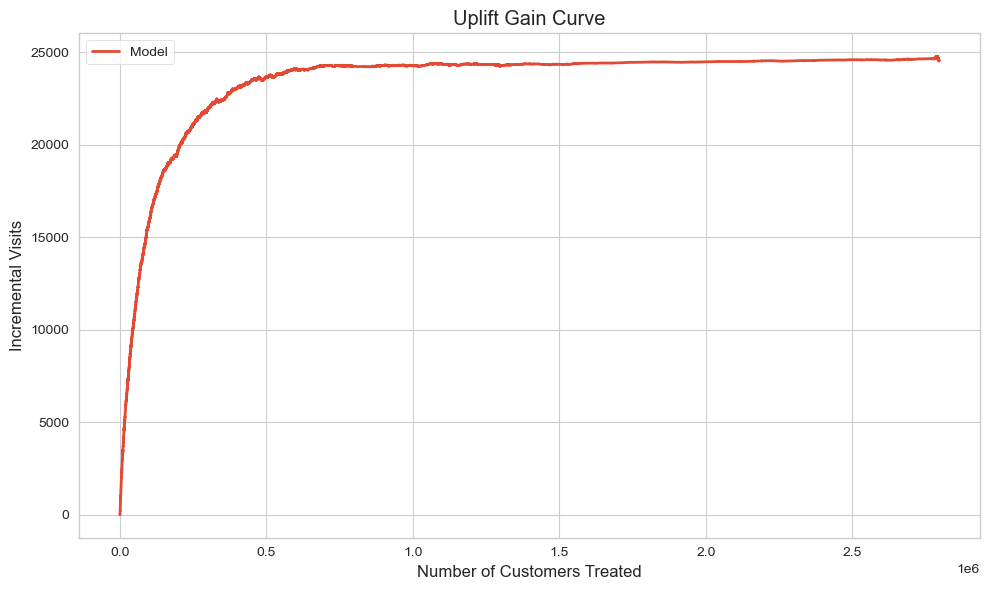

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(incremental_visits) + 1), incremental_visits, label='Model', linewidth=2)
plt.xlabel('Number of Customers Treated')
plt.ylabel('Incremental Visits')
plt.title('Uplift Gain Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Normalized Qini Curve

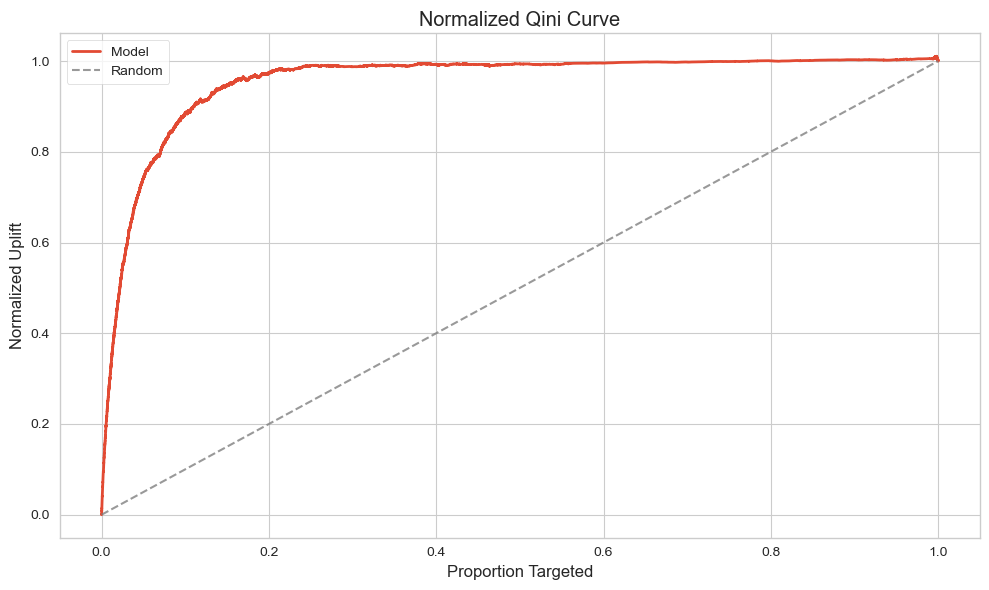

In [46]:
normalized_gain = incremental_visits / total_gain

plt.figure(figsize=(10, 6))
plt.plot(x, normalized_gain, label='Model', linewidth=2)
plt.plot(x, x, '--', color='gray', label='Random', alpha=0.8)
plt.xlabel('Proportion Targeted')
plt.ylabel('Normalized Uplift')
plt.title('Normalized Qini Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

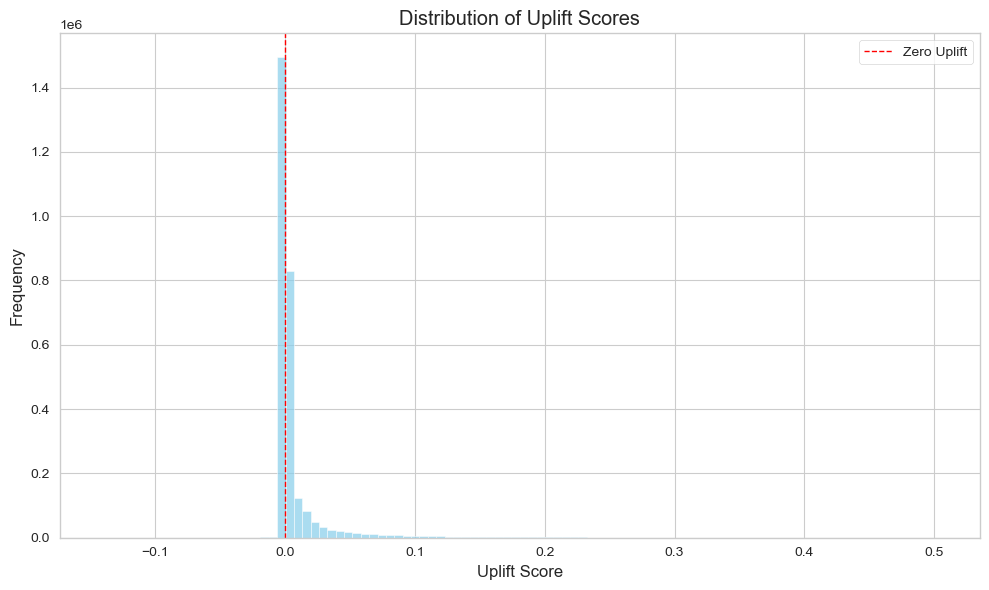

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(uplift_score, bins=100, alpha=0.7, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Zero Uplift')
plt.xlabel('Uplift Score')
plt.ylabel('Frequency')
plt.title('Distribution of Uplift Scores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 📊 Business Interpretation:
- Model is significantly better than random? → Qini Coefficient: 11174.9461
- Top 30% users capture 98.7% of total incremental visits
- Negative uplift exists，we should avoid disturbing these users